In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Week 1

## Time Series

- An ordered sequence of values that are usually equally spaced over time.
- **Univariate**- Single variables (like stock value) plotted on the y-axis.
- **Multivariate**- Multiple values at each time step.

**Applications of ML in time-series data**
1. Prediction of forecasting based on the data
2. Imputation- Projecting back into the past
3. Detecting anomalies
4. Analyze the time series to spot patterns in them that determine what generated the series itself. A classic example of this is to analyze sound waves to spot words in them which can be used as a neural network for speech recognition.

**Common Patterns**
1. Trend: Time series have a specific direction in which they are moving
2. Seasonality: When patterns repeat at specific intervals
3. Combination of Trend and Seasonality
4. White Noise: Random data
5. Autocorrelation: correlates with a delayed copy of itself often called a lag.

Breaking the mold for typical machine: learning where we always assume that more data is better.

But for time series forecasting it really depends on the time series. If it's **stationary**, meaning its behavior does not change over time, then great. The more data you have the better. But if it's **not stationary** then the optimal time window that you should use for training will vary.

## ML Concepts

### Train, Validation and Test Sets

1. Fixed Partitioning
2. Roll-Forward Partitioning

### Metrics for Evaluating Performance

```
errors = forecasts - actual
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean() --> does not penalize large errors as much as the mse does
mape = np.abs(errors / x_valid).mean()
```

In [2]:
x_valid = list(range(1, 11))
print(f"X       : {x_valid}")

forecast = list(range(0, 10))
print(f"Forecast: {forecast}")

error = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(f"Error  : {error}")

X       : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Forecast: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Error  : 1


### Moving Average and Differencing

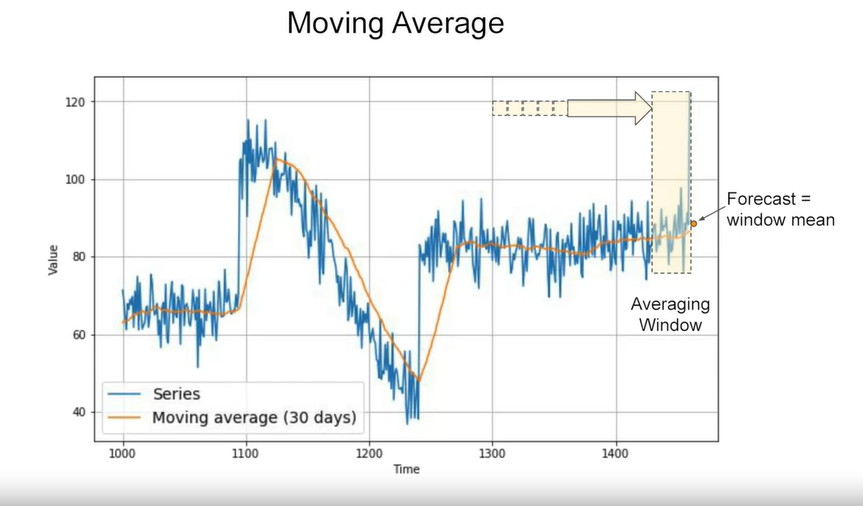

`Nicely eliminates a lot of the noise and it gives us a curve roughly emulating the original series, but it does not anticipate trend or seasonality.`

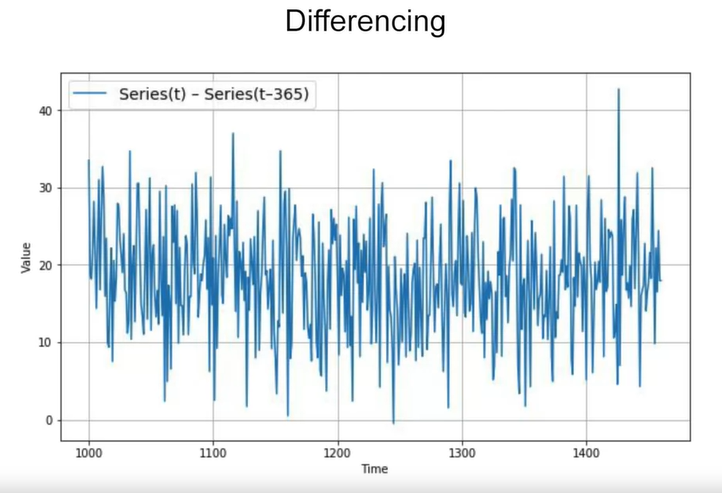

`Remove the trend and seasonality from the time series with a technique called differencing`

# Week 2

**Applying DNNs to time series data**

- An important technique: tuning the learning rate.

## Preparing Features and Labels using `tf.data.Dataset()`

### Simple Dataset: `range`

In [3]:
dataset = tf.data.Dataset.range(10)
print(dataset)
# Print elements
for val in dataset:
    print(val.numpy())

<RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
0
1
2
3
4
5
6
7
8
9


### Windowing: `window`

In [4]:
windowed_dataset = dataset.window(size=5, shift=1)
'''
    size = # of elements per window
    shift = move the window by shift # of elements
'''
for window in windowed_dataset:
    print(window) # returns tf.data.Dataset generator

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [5]:
# Printing data inside tf.data.Dataset
for window in windowed_dataset:
    print([item.numpy() for item in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9]
[7, 8, 9]
[8, 9]
[9]


`drop_remainder`: To ensure that only windows with only the specified size are retained

In [6]:
dataset = tf.data.Dataset.range(10)

dataset = dataset.window(size=5, shift=1, drop_remainder=True)

for window_dataset in dataset:
    print([item.numpy() for item in window_dataset])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


### Flatten the Windows: `flat_map()`

During training, we want the windows to be tensors instead of tf.data.Dataset.

To convert, pass a mapping function the the `flat_map()` method.

In [7]:
dataset = tf.data.Dataset.range(10)

dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
# Argument of batch = windows size
dataset = dataset.flat_map(lambda window : window.batch(5))

# Print
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


### Group into features and labels: `map()`

In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window : window.batch(5))

# Return a tuple (first 4 features, last feature)
dataset = dataset.map(lambda window : (window[:-1], window[-1]))

# Print
for x, y in dataset:
    print(f"x = {x.numpy()}")
    print(f"y = {y.numpy()}\n")

x = [0 1 2 3]
y = 4

x = [1 2 3 4]
y = 5

x = [2 3 4 5]
y = 6

x = [3 4 5 6]
y = 7

x = [4 5 6 7]
y = 8

x = [5 6 7 8]
y = 9



### Shuffle the data: `shuffle()`

Done to avoid **_sequence bias_**. This refers to the neural network overfitting to the order of inputs and consequently, it will not perform well when it does not see that particular order when testing.

In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window : window.batch(5))
dataset = dataset.map(lambda window : (window[:-1], window[-1]))

# For perfect shuffling, a buffer size greater than or equal to the 
# full size of the dataset is required.
dataset = dataset.shuffle(buffer_size = 10)

# Print
for x, y in dataset:
    print(f"x = {x.numpy()}")
    print(f"y = {y.numpy()}\n")

x = [4 5 6 7]
y = 8

x = [0 1 2 3]
y = 4

x = [5 6 7 8]
y = 9

x = [1 2 3 4]
y = 5

x = [2 3 4 5]
y = 6

x = [3 4 5 6]
y = 7



### Create batches for training: `batch()` and `prefetch()`

- `batch()` will return a batched dataset with the specified number of samples.
- As a rule of thumb, it is also good to specify a `prefetch()` step. This optimizes the execution time when the model is already training. By specifying a prefetch buffer_size of 1 as shown below, Tensorflow will prepare the next one batch in advance (i.e. putting it in a buffer) while the current batch is being consumed by the model.

In [10]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window : window.batch(5))
dataset = dataset.map(lambda window : (window[:-1], window[-1]))
dataset = dataset.shuffle(buffer_size = 10)

dataset = dataset.batch(2).prefetch(1)

# Print
for x, y in dataset:
    print(f"x = {x.numpy()}")
    print(f"y = {y.numpy()}\n")

x = [[2 3 4 5]
 [4 5 6 7]]
y = [6 8]

x = [[0 1 2 3]
 [5 6 7 8]]
y = [4 9]

x = [[3 4 5 6]
 [1 2 3 4]]
y = [7 5]



## Simple DNN for Time Series Data

Create sample data

In [11]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end], series_num[start:end], format)
    else:
        plt.plot(time[start:end], series[start:end], format)
    
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


def trend(time, slope=0):
    series = slope * time
    return series


def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

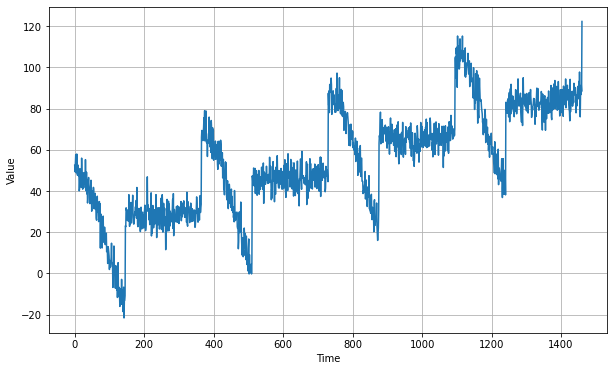

In [12]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

Create tf.data.Dataset

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [14]:
# Split the dataset
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Build the Model

In [15]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

**Learning Rate Scheduler Callback**

In [16]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [17]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss="mse", optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 20ms/step - loss: 7535.1831 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 2843.6172 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 1118.9788 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 518.5121 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 277.0988 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 171.5965 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 129.7474 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 111.8157 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 105.4923 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 103.1029 - lr: 2.8184e-08
Epoch

31/31 [==============================] - 0s 1ms/step - loss: 384.6189 - lr: 1.2589e-04
Epoch 84/100
31/31 [==============================] - 0s 521us/step - loss: 390.6805 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 0s 521us/step - loss: 387.9559 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 0s 1ms/step - loss: 383.3176 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 0s 1ms/step - loss: 387.9582 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 0s 1ms/step - loss: 452.2585 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 0s 521us/step - loss: 392.8245 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 0s 1ms/step - loss: 394.3461 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 0s 1ms/step - loss: 398.2992 - lr: 3.1623e-04
Epoch 92/100
31/31 [==============================] - 0s 2ms/step - loss: 395.6899 - lr: 3.5481e-04
Epoch 9

Plot the results of training to find **optimal learning rate**

(1e-08, 0.001, 0.0, 300.0)

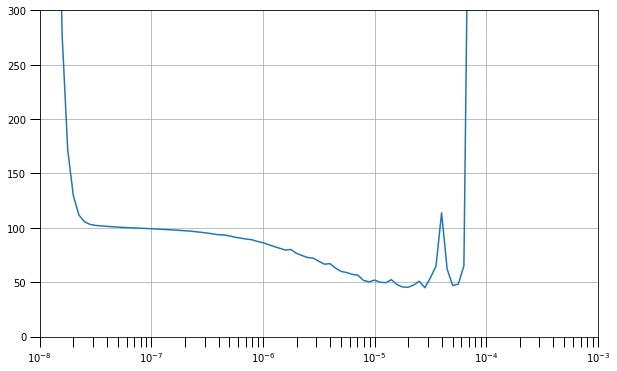

In [18]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 300])

```The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will be shown in the next cells.```

Basically, pick a stable point near the minimum.

In [19]:
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model_tune.compile(loss="mse", optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 354.2872
Epoch 2/100
31/31 [==============================] - 0s 521us/step - loss: 94.2887
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 72.1905
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 66.3930
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 63.9447
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 62.4565
Epoch 7/100
31/31 [==============================] - 0s 521us/step - loss: 61.0969
Epoch 8/100
31/31 [==============================] - 0s 521us/step - loss: 60.8841
Epoch 9/100
31/31 [==============================] - 0s 522us/step - loss: 59.4004
Epoch 10/100
31/31 [==============================] - 0s 521us/step - loss: 58.5359
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 58.1595
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 57.6676
Epoch 13/100
3

31/31 [==============================] - 0s 1ms/step - loss: 44.5509


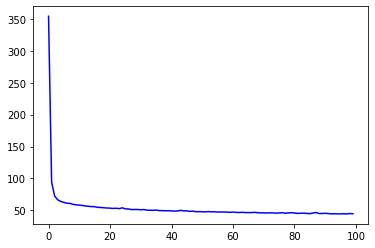

In [20]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

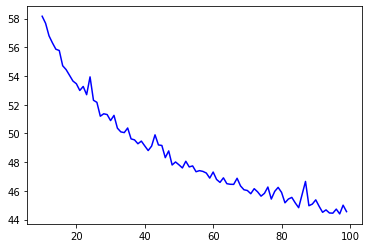

In [21]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

Evaluate model on Validation Data

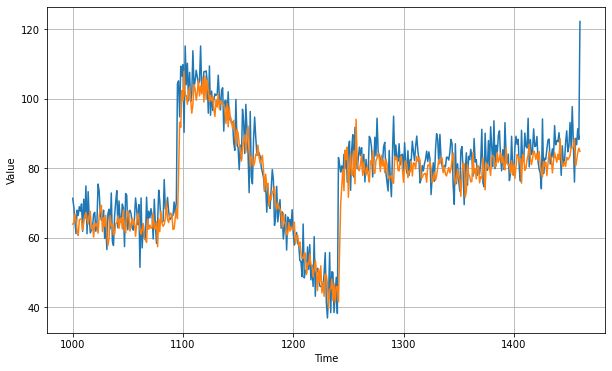

In [22]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Metrics

In [23]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

52.109367
5.293381


# Week 3

**Applying RNNs and LSTMs to Time Sequence Data**

## RNNs

- Input shape of Recurrent Layers = \[batch size, # time steps, # dims\]
- Therefore, input is 3-dimensional.
- \# dims = 1 if data is univariate, more if multivariate

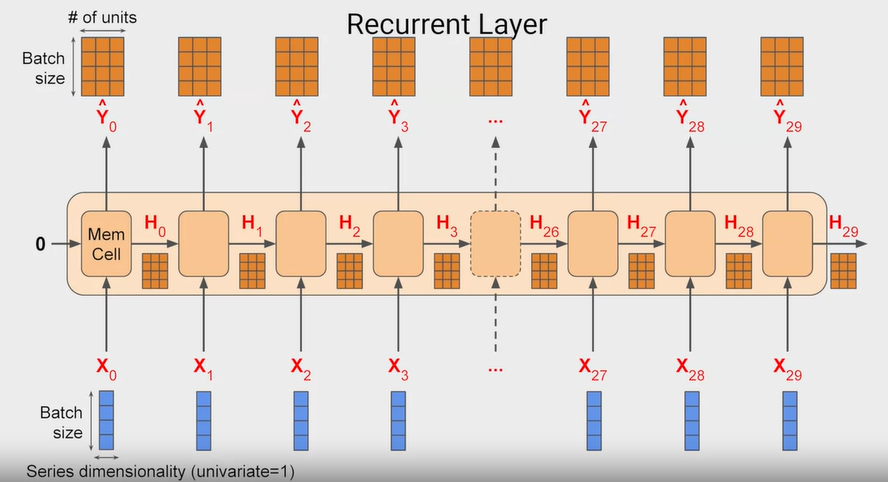

### Model with `SimpleRNN` layers + `Lambda` layers

`SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using `Lambda` layers.

In [24]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


`Normally, you can just a have a Dense layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the activation functions you used in your model. SimpleRNN uses tanh by default and that has an output range of [-1,1]. You will use another Lambda() layer to scale the output by 100 before it adjusts the layer weights.`

**Training with Learning Rate Scheduler callback**

We use the Huber Loss to minimizer sensitivity to outliers.

In [25]:
# Initizlier LR scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch/20))

# Set optimizer, no need to set learning_rate here
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Compile model with Huber loss
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Fit model with LR scheduler callback
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 50.7036 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 49.3807 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 47.7934 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 46.0398 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 44.0896 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 41.9234 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 39.5179 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 36.8477 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 33.9156 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 30.7490 - lr: 2.8184e-08
Epoch 11/100
31/31 

31/31 [==============================] - 0s 5ms/step - loss: 16.8345 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 16.5257 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 17.5223 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 17.1665 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 17.1850 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 17.2780 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 0s 6ms/step - loss: 17.5521 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 0s 6ms/step - loss: 17.5248 - lr: 3.1623e-04
Epoch 92/100
31/31 [==============================] - 0s 5ms/step - loss: 15.5434 - lr: 3.5481e-04
Epoch 93/100
31/31 [==============================] - 0s 5ms/step - loss: 17.3179 - lr: 3.9811e-04
Epoch 94/100
31/31 [===

Visualizing results to pick optimal learning rate

(1e-07, 0.0001, 0.0, 20.0)

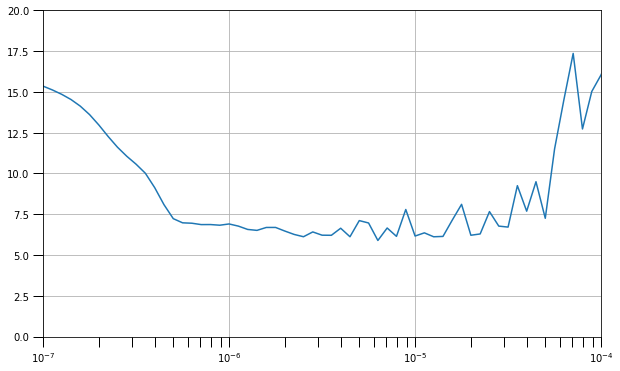

In [26]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20)) # Define learning rate array

# Plt props
plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both') # Increase tickmarks size

plt.axis([1e-7, 1e-4, 0, 20]) # Set plot boundaries

Training with lr = 1e-6

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 10.6385 - mae: 11.1269
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 7.6466 - mae: 8.1312
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 7.3374 - mae: 7.8181
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 7.3570 - mae: 7.8388
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 7.2097 - mae: 7.6952
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 7.0734 - mae: 7.5554
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 7.1211 - mae: 7.6000
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 6.9049 - mae: 7.3889
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 6.8905 - mae: 7.3711
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 7.1081 - mae: 7.5895
Epoch 11/100
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 6ms/step - loss: 5.0038 - mae: 5.4787
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 5.0888 - mae: 5.5674
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 5.1057 - mae: 5.5853
Epoch 90/100
31/31 [==============================] - 0s 6ms/step - loss: 4.9635 - mae: 5.4385
Epoch 91/100
31/31 [==============================] - 0s 6ms/step - loss: 5.0053 - mae: 5.4812
Epoch 92/100
31/31 [==============================] - 0s 6ms/step - loss: 5.0979 - mae: 5.5779
Epoch 93/100
31/31 [==============================] - 0s 6ms/step - loss: 5.1040 - mae: 5.5851
Epoch 94/100
31/31 [==============================] - 0s 7ms/step - loss: 5.0747 - mae: 5.5511
Epoch 95/100
31/31 [==============================] - 0s 6ms/step - loss: 4.8733 - mae: 5.3512
Epoch 96/100
31/31 [==============================] - 0s 6ms/step - loss: 5.0745 - mae: 5.5530
Epoch 97/100
31/31 [==============================] - 0s 6ms/st

**Make predictions**

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


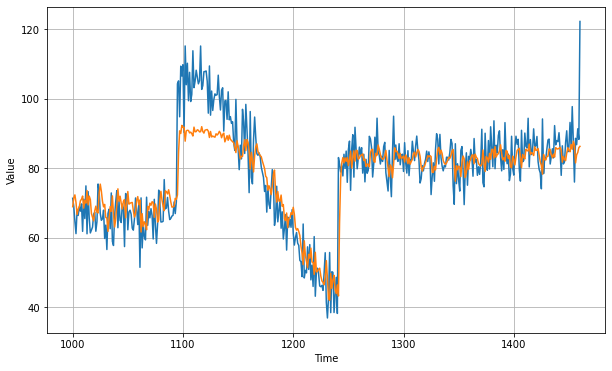

In [28]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

**Optimize the prediction step**

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [29]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w : w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    # No shuffle as we want the output to be in its proper sequence in order
    # to compare with the validation set
    forecast = model.predict(dataset)
    return forecast

Instantaneous predictions

15/15 [==============================] - 0s 4ms/step


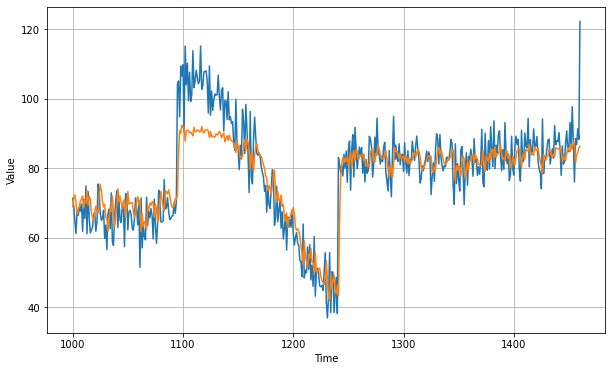

In [30]:
forecast_series = series[split_time - window_size : -1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

Metrics

In [31]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

61.408237
5.7975774


## LSTMs

In [32]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

LSTMS require more parameters when compared to RNNs (33k vs 4k).

Tuning the learning rate

In [33]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 16ms/step - loss: 31.3818 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 30.5845 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 29.6055 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 28.4795 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 27.2135 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 25.7689 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 24.2087 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 17ms/step - loss: 22.5210 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 20.1767 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 17ms/step - loss: 18.4845 - lr: 2.8184e-08
Epoch 11/

31/31 [==============================] - 1s 18ms/step - loss: 8.3090 - lr: 1.2589e-04
Epoch 84/100
31/31 [==============================] - 1s 18ms/step - loss: 7.7942 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 1s 18ms/step - loss: 6.7762 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 1s 18ms/step - loss: 6.8570 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 1s 17ms/step - loss: 8.0631 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 1s 18ms/step - loss: 6.7414 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 1s 18ms/step - loss: 7.0778 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 1s 18ms/step - loss: 9.0057 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 1s 18ms/step - loss: 7.9800 - lr: 3.1623e-04
Epoch 92/100
31/31 [==============================] - 1s 18ms/step - loss: 7.4383 - lr: 3.5481e-04
Epoch 93/100
31/31 [===

(1e-08, 0.001, 0.0, 30.0)

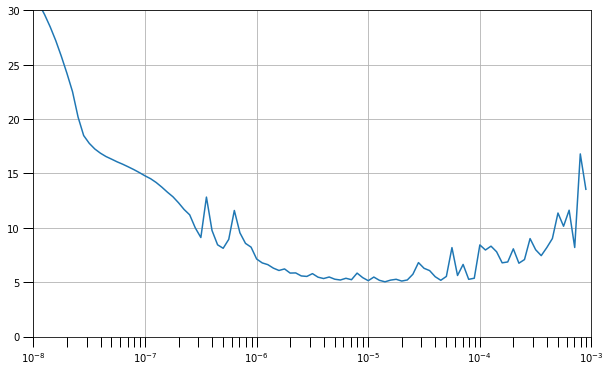

In [34]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 30])

Optimal learning rate = 2e-6

In [35]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

learning_rate = 2e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 20ms/step - loss: 19.3493 - mae: 19.8411
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 9.1720 - mae: 9.6550
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 7.3274 - mae: 7.8126
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 6.7194 - mae: 7.1993
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 6.3565 - mae: 6.8364
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 6.1492 - mae: 6.6318
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 5.9909 - mae: 6.4722
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 5.8312 - mae: 6.3119
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 5.8042 - mae: 6.2860
Epoch 10/100
31/31 [==============================] - 1s 23ms/step - loss: 5.7126 - mae: 6.1956
Epoch 11/100
31/31 [===========================

31/31 [==============================] - 1s 22ms/step - loss: 4.4925 - mae: 4.9684
Epoch 87/100
31/31 [==============================] - 1s 23ms/step - loss: 4.4172 - mae: 4.8924
Epoch 88/100
31/31 [==============================] - 1s 22ms/step - loss: 4.5414 - mae: 5.0159
Epoch 89/100
31/31 [==============================] - 1s 23ms/step - loss: 4.3966 - mae: 4.8724
Epoch 90/100
31/31 [==============================] - 1s 24ms/step - loss: 4.4458 - mae: 4.9244
Epoch 91/100
31/31 [==============================] - 1s 26ms/step - loss: 4.3880 - mae: 4.8630
Epoch 92/100
31/31 [==============================] - 1s 26ms/step - loss: 4.4821 - mae: 4.9570
Epoch 93/100
31/31 [==============================] - 1s 26ms/step - loss: 4.4070 - mae: 4.8815
Epoch 94/100
31/31 [==============================] - 1s 24ms/step - loss: 4.5235 - mae: 5.0005
Epoch 95/100
31/31 [==============================] - 1s 22ms/step - loss: 4.4652 - mae: 4.9381
Epoch 96/100
31/31 [==============================] -

**Predictions and Metrics**

15/15 [==============================] - 1s 8ms/step


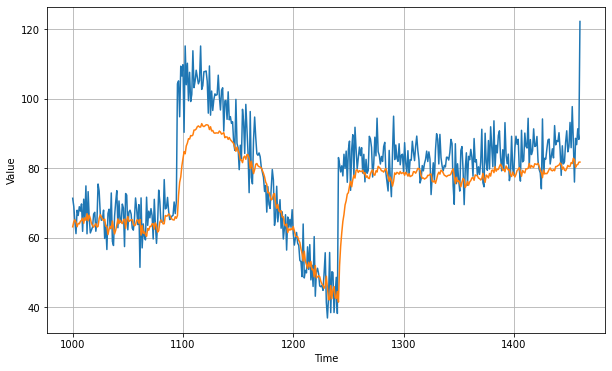

In [36]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [37]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

79.34326
6.5422354


**Validation during Training**

In [38]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 [==============================] - 7s 75ms/step - loss: 10.7469 - mae: 11.2376 - val_loss: 26.5197 - val_mae: 27.0179
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 7.9319 - mae: 8.4188 - val_loss: 18.7754 - val_mae: 19.2727
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 7.2539 - mae: 7.7377 - val_loss: 18.4148 - val_mae: 18.9100
Epoch 4/100
31/31 [==============================] - 1s 34ms/step - loss: 6.9519 - mae: 7.4365 - val_loss: 16.0894 - val_mae: 16.5840
Epoch 5/100
31/31 [==============================] - 1s 34ms/step - loss: 6.6226 - mae: 7.1066 - val_loss: 15.7635 - val_mae: 16.2583
Epoch 6/100
31/31 [==============================] - 1s 40ms/step - loss: 6.4043 - mae: 6.8864 - val_loss: 14.8201 - val_mae: 15.3140
Epoch 7/100
31/31 [==============================] - 1s 42ms/step - loss: 6.2191 - mae: 6.7029 - val_loss: 12.8799 - val_mae: 13.3707
Epoch 8/100
31/31 [==============================] - 1s 41ms

31/31 [==============================] - 1s 36ms/step - loss: 4.6086 - mae: 5.0883 - val_loss: 6.3196 - val_mae: 6.7998
Epoch 63/100
31/31 [==============================] - 1s 36ms/step - loss: 4.5536 - mae: 5.0297 - val_loss: 5.8631 - val_mae: 6.3454
Epoch 64/100
31/31 [==============================] - 1s 36ms/step - loss: 4.7019 - mae: 5.1803 - val_loss: 6.5811 - val_mae: 7.0606
Epoch 65/100
31/31 [==============================] - 1s 35ms/step - loss: 4.5981 - mae: 5.0753 - val_loss: 7.0528 - val_mae: 7.5366
Epoch 66/100
31/31 [==============================] - 1s 35ms/step - loss: 4.5528 - mae: 5.0235 - val_loss: 5.8182 - val_mae: 6.3030
Epoch 67/100
31/31 [==============================] - 1s 35ms/step - loss: 4.5857 - mae: 5.0613 - val_loss: 6.3979 - val_mae: 6.8790
Epoch 68/100
31/31 [==============================] - 1s 35ms/step - loss: 4.5892 - mae: 5.0670 - val_loss: 6.3025 - val_mae: 6.7809
Epoch 69/100
31/31 [==============================] - 1s 36ms/step - loss: 4.5410 

**Note**: HDF5 format does not fully support Lambda layers. Therefore, we use the SavedModel format.

# Week 4

**1D ConvNets + Real World Data (Sunspot Dataset)**

## Convolutions on Time Sequence Data

**Padding**

For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
             metrics=["mae"])

model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 17ms/step - loss: 23.7671 - mae: 24.2626
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 6.2014 - mae: 6.6801
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 5.9189 - mae: 6.4003
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 5.9805 - mae: 6.4617
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 6.1194 - mae: 6.6040
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 5.5913 - mae: 6.0716
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 6.3604 - mae: 6.8456
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 5.1062 - mae: 5.5829
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 5.8571 - mae: 6.3348
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 6.0012 - mae: 6.4832
Epoch 11/100
31/31 [===========================

31/31 [==============================] - 1s 21ms/step - loss: 4.4987 - mae: 4.9753
Epoch 87/100
31/31 [==============================] - 1s 18ms/step - loss: 5.0992 - mae: 5.5787
Epoch 88/100
31/31 [==============================] - 1s 22ms/step - loss: 4.5417 - mae: 5.0183
Epoch 89/100
31/31 [==============================] - 1s 20ms/step - loss: 4.5610 - mae: 5.0379
Epoch 90/100
31/31 [==============================] - 1s 23ms/step - loss: 4.5155 - mae: 4.9975
Epoch 91/100
31/31 [==============================] - 1s 23ms/step - loss: 4.4001 - mae: 4.8835
Epoch 92/100
31/31 [==============================] - 1s 19ms/step - loss: 4.5079 - mae: 4.9852
Epoch 93/100
31/31 [==============================] - 1s 20ms/step - loss: 4.5109 - mae: 4.9919
Epoch 94/100
31/31 [==============================] - 1s 19ms/step - loss: 4.4177 - mae: 4.8933
Epoch 95/100
31/31 [==============================] - 1s 20ms/step - loss: 4.7915 - mae: 5.2663
Epoch 96/100
31/31 [==============================] -

15/15 [==============================] - 1s 8ms/step


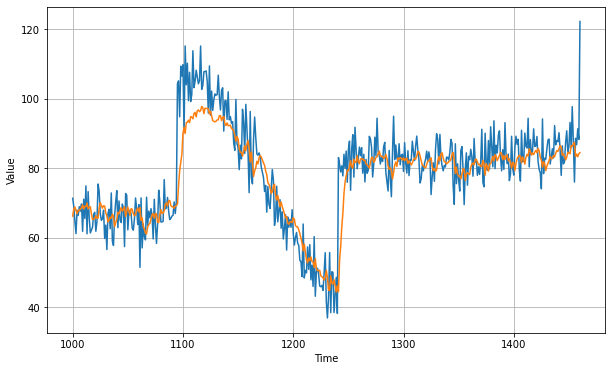

In [42]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

We can do better, particularly around the peak at t=1100. Ways to improve:
- Train for longer, as loss curve shows the loss slowly diminishing.
- Use bidirectional LSTM.

In [45]:
# Using bidirectional LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
             metrics=["mae"])

history = model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 20ms/step - loss: 13.9103 - mae: 14.4000
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 6.3800 - mae: 6.8604
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 6.7726 - mae: 7.2564
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 5.9531 - mae: 6.4351
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 5.2780 - mae: 5.7579
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 6.3539 - mae: 6.8369
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 6.5485 - mae: 7.0354
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 4.9653 - mae: 5.4457
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss: 5.0953 - mae: 5.5712
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 5.3600 - mae: 5.8418
Epoch 11/100
31/31 [===========================

31/31 [==============================] - 1s 29ms/step - loss: 4.6774 - mae: 5.1544
Epoch 87/100
31/31 [==============================] - 1s 28ms/step - loss: 4.3048 - mae: 4.7775
Epoch 88/100
31/31 [==============================] - 1s 29ms/step - loss: 4.8307 - mae: 5.3096
Epoch 89/100
31/31 [==============================] - 1s 29ms/step - loss: 4.3126 - mae: 4.7921
Epoch 90/100
31/31 [==============================] - 1s 29ms/step - loss: 4.6958 - mae: 5.1760
Epoch 91/100
31/31 [==============================] - 1s 29ms/step - loss: 4.1496 - mae: 4.6243
Epoch 92/100
31/31 [==============================] - 1s 28ms/step - loss: 4.2228 - mae: 4.6955
Epoch 93/100
31/31 [==============================] - 1s 29ms/step - loss: 4.0479 - mae: 4.5203
Epoch 94/100
31/31 [==============================] - 1s 28ms/step - loss: 4.0581 - mae: 4.5297
Epoch 95/100
31/31 [==============================] - 1s 28ms/step - loss: 4.3268 - mae: 4.8055
Epoch 96/100
31/31 [==============================] -

15/15 [==============================] - 2s 11ms/step


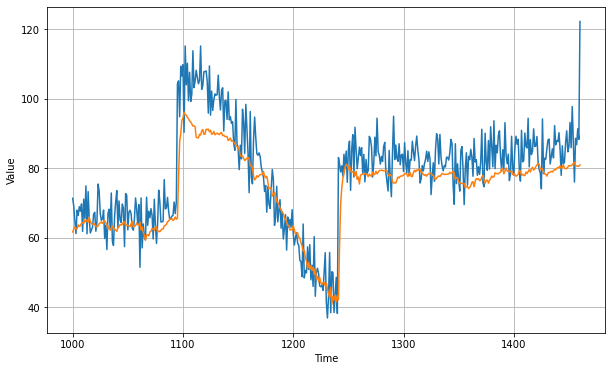

In [46]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))

Model may begin to overfit, if we observe small spikes in the loss curve, we can experiment with different batch sizes (greater and smaller than 32). According to lecture, 16 works best for the current dataset.

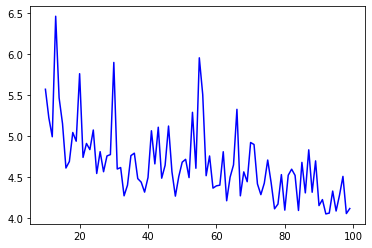

In [47]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

## Learning Rate Scheduler: Exponential Decay

Use the learning rate defined by:
```python
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

In [48]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)